# Mutual Information Metric

The `MutualInformationImageToImageMetric` class computes the mutual information between two images, i.e. the degree to which information content in one image is dependent on the other image. This example shows how `MutualInformationImageToImageMetric` can be used to map transformation parameters and register two images using a gradient ascent algorithm.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from urllib.request import urlretrieve

import itk
from itkwidgets import view

In [2]:
dim = 2
ImageType = itk.Image[itk.F, dim]
FixedImageType = ImageType
MovingImageType = ImageType

### Retrieve fixed and moving images for registration

We aim to register two slice images, one of which has an arbitrary offset.

In [3]:
fixed_img_path = "BrainT1SliceBorder20.png"
moving_img_path = "BrainProtonDensitySliceShifted13x17y.png"

In [4]:
if not os.path.exists(fixed_img_path):
    url = "https://data.kitware.com/api/v1/file/5cad1ae88d777f072b18183d/download"
    urlretrieve(url, fixed_img_path)
if not os.path.exists(moving_img_path):
    url = "https://data.kitware.com/api/v1/file/5cad1ae88d777f072b181831/download"
    urlretrieve(url, moving_img_path)

In [5]:
fixed_img = itk.imread("BrainT1SliceBorder20.png", itk.F)
moving_img = itk.imread("BrainProtonDensitySliceShifted13x17y.png", itk.F)


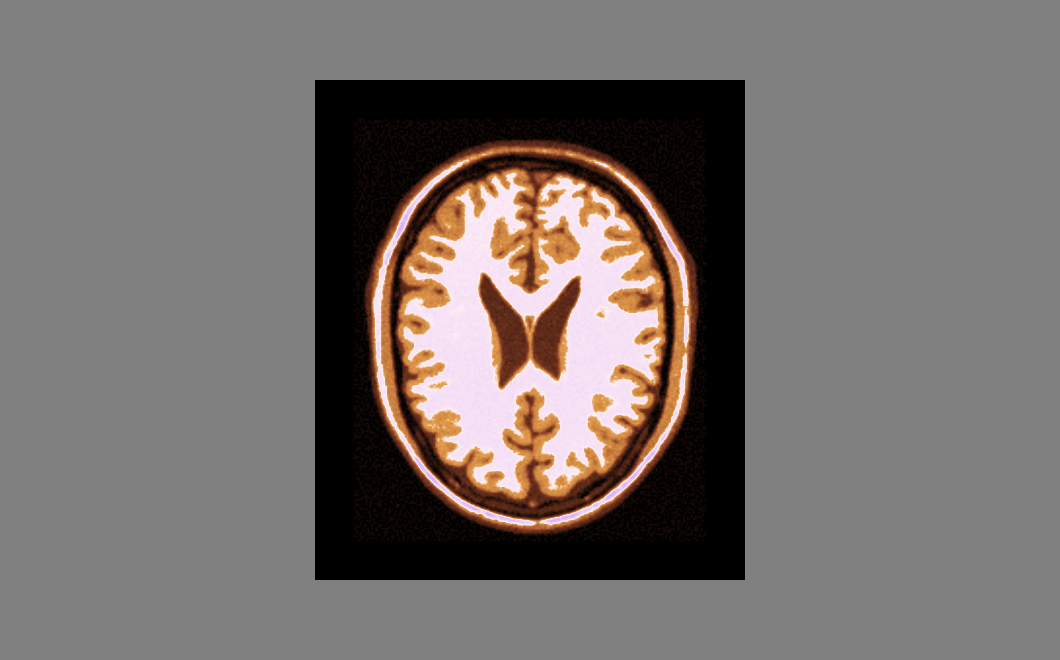
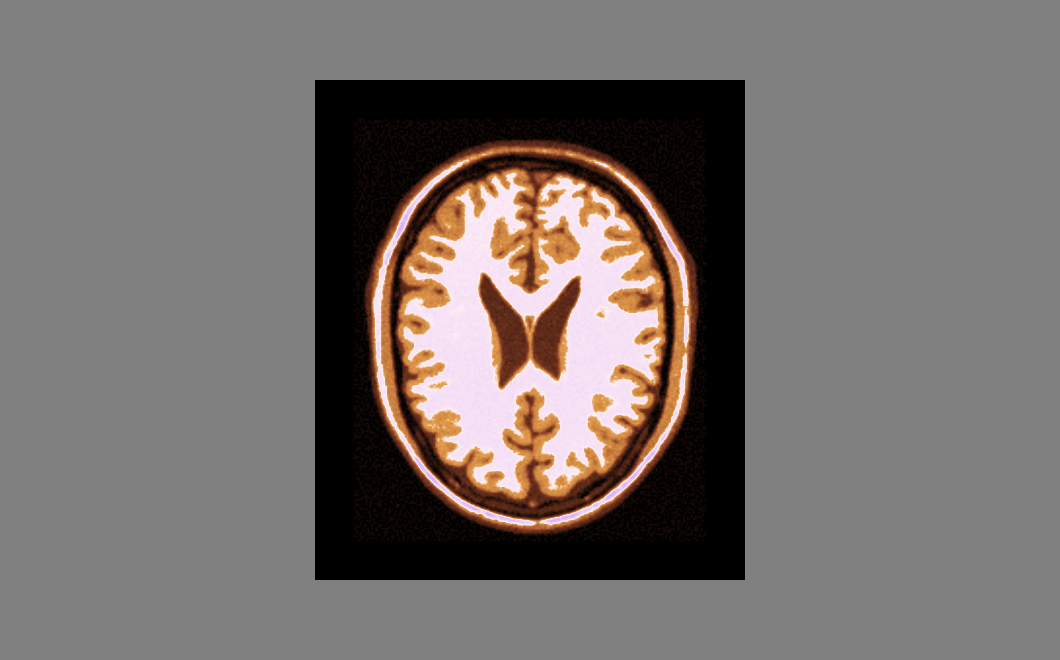

<IPython.core.display.Javascript object>

In [6]:
view(fixed_img)


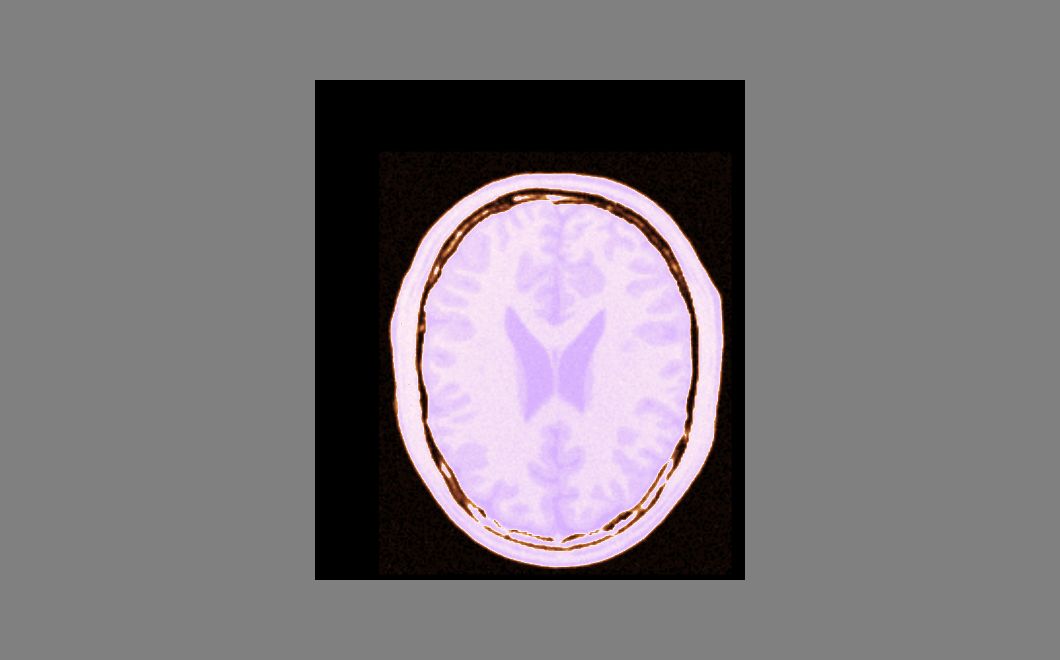
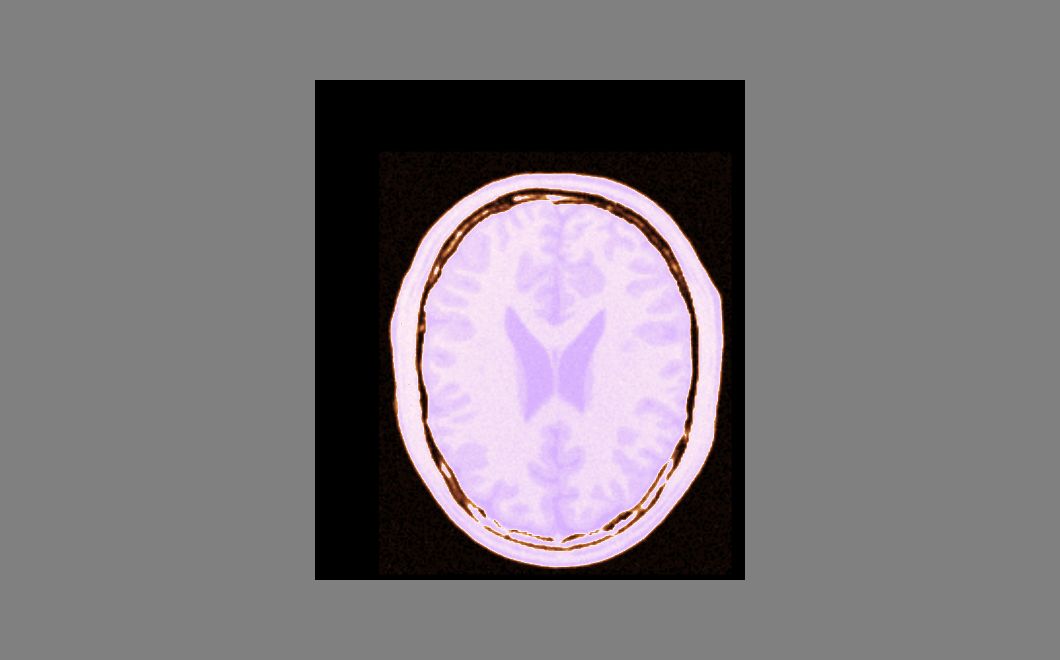

<IPython.core.display.Javascript object>

In [7]:
view(moving_img)

### Prepare images for registration

In [8]:
fixed_normalized_image = itk.normalize_image_filter(fixed_img)
fixed_smoothed_image = itk.discrete_gaussian_image_filter(fixed_normalized_image, variance=2.0)

moving_normalized_image = itk.normalize_image_filter(moving_img)
moving_smoothed_image = itk.discrete_gaussian_image_filter(moving_normalized_image, variance=2.0)


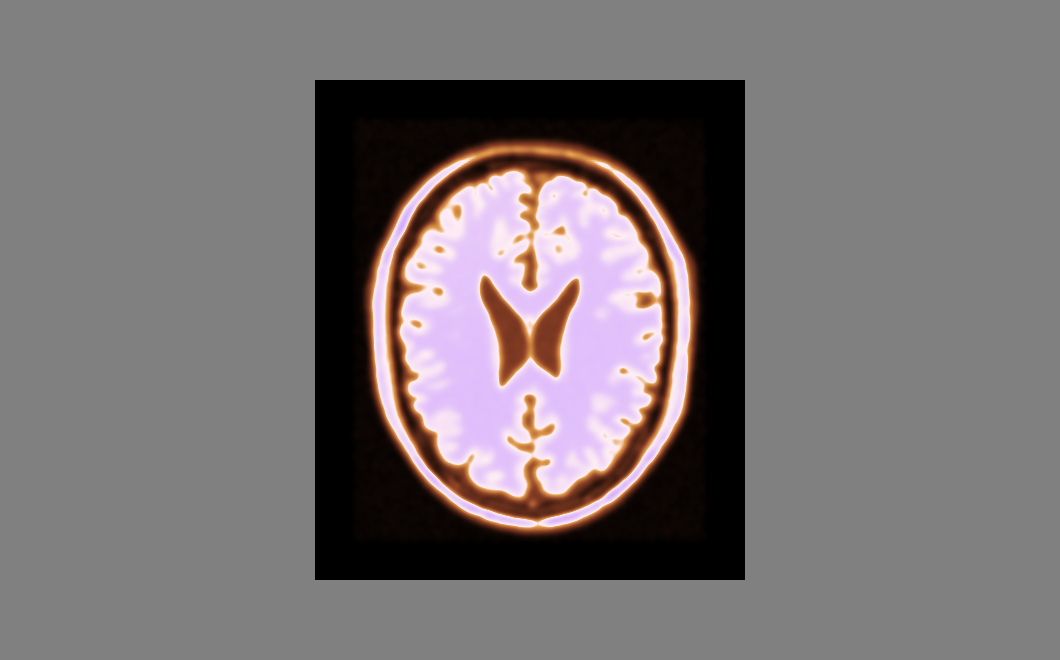
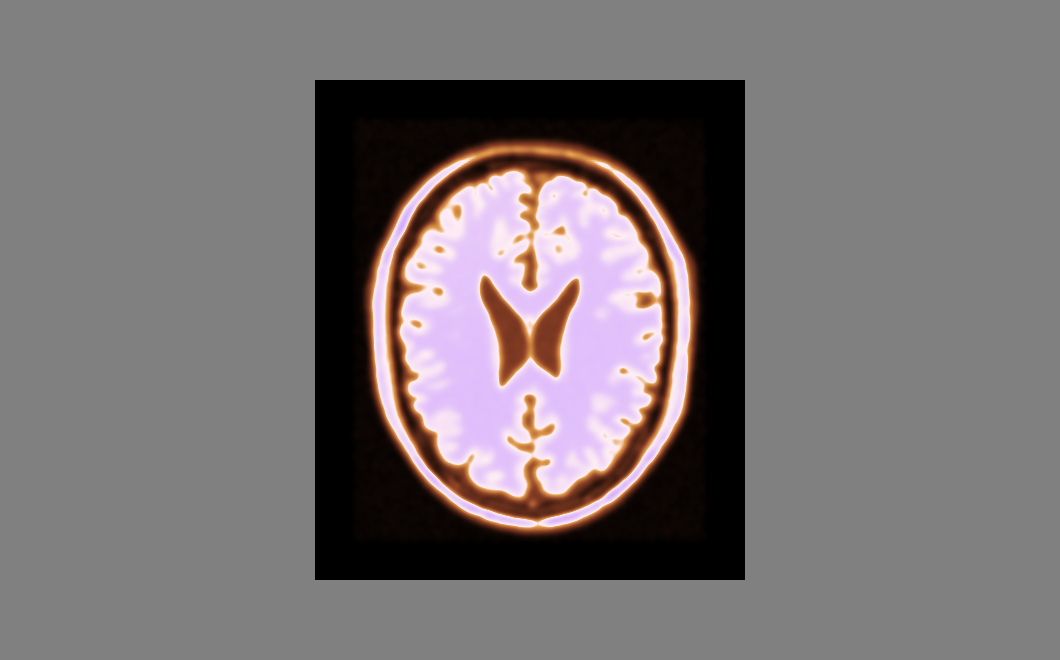

<IPython.core.display.Javascript object>

In [10]:
view(fixed_smoothed_image)

## Plot the `MutualInformationImageToImageMetric` surface

For this relatively simple example we seek to adjust only the x- and y-offset of the moving image with a `TranslationTransform`. We can acquire `MutualInformationImageToImageMetric` values comparing the two images at many different possible offset pairs with `ExhaustiveOptimizer` and visualize this data set as a surface with `matplotlib`.

In [11]:
# Move at most 20 pixels away from the initial position
window_size = [20, 20]
# Collect 100 steps of data along each axis
n_steps = [100, 100]

In [12]:
TransformType = itk.TranslationTransform[itk.D, dim]
OptimizerType = itk.GradientDescentOptimizer
ExhaustiveOptimizerType = itk.ExhaustiveOptimizer
MetricType = itk.MutualInformationImageToImageMetric[ImageType, ImageType]
RegistrationType = itk.ImageRegistrationMethod[ImageType, ImageType]
InterpolatorType = itk.LinearInterpolateImageFunction[ImageType, itk.D]

In [13]:
transform = TransformType.New()
metric = MetricType.New()
optimizer = ExhaustiveOptimizerType.New()
registrar = RegistrationType.New()
interpolator = InterpolatorType.New()

In [14]:
metric.SetNumberOfSpatialSamples(100)
metric.SetFixedImageStandardDeviation(0.4)
metric.SetMovingImageStandardDeviation(0.4)

In [15]:
optimizer.SetNumberOfSteps(n_steps)

# Initialize scales and set back to optimizer
scales = optimizer.GetScales()
scales.SetSize(2)
scales.SetElement(0, window_size[0] / n_steps[0])
scales.SetElement(1, window_size[1] / n_steps[1])
optimizer.SetScales(scales)

In [16]:
registrar.SetFixedImage(fixed_smoothed_image)
registrar.SetMovingImage(moving_smoothed_image)
registrar.SetOptimizer(optimizer)
registrar.SetTransform(transform)
registrar.SetInterpolator(interpolator)
registrar.SetMetric(metric)

registrar.SetFixedImageRegion(fixed_img.GetBufferedRegion())
registrar.SetInitialTransformParameters(transform.GetParameters())

In [17]:
# Collect data describing the parametric surface with an observer
surface = dict()


def print_iteration():
    surface[tuple(optimizer.GetCurrentPosition())] = optimizer.GetCurrentValue()


optimizer.AddObserver(itk.IterationEvent(), print_iteration)

0

In [18]:
registrar.Update()

In [19]:
# Check the extreme positions within the observed window
max_position = list(optimizer.GetMaximumMetricValuePosition())
min_position = list(optimizer.GetMinimumMetricValuePosition())

max_val = optimizer.GetMaximumMetricValue()
min_val = optimizer.GetMinimumMetricValue()

print(max_position)
print(min_position)

[13.600000000000001, 16.0]
[-8.200000000000001, -9.200000000000001]


In [20]:
# Set up values for the plot
x_vals = [list(set([x[i] for x in surface.keys()])) for i in range(0, 2)]

for i in range(0, 2):
    x_vals[i].sort()

X, Y = np.meshgrid(x_vals[0], x_vals[1])
Z = np.array([[surface[(x0, x1)] for x1 in x_vals[0]] for x0 in x_vals[1]])

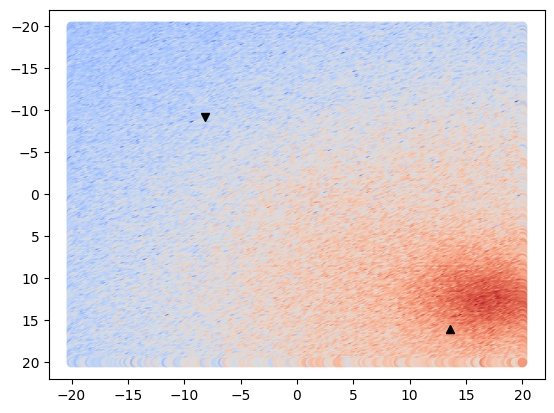

In [21]:
# Plot the surface as a 2D heat map
fig = plt.figure()
plt.gca().invert_yaxis()
ax = plt.gca()

surf = ax.scatter(X, Y, c=Z, cmap=cm.coolwarm)
ax.plot(max_position[0], max_position[1], "k^")
ax.plot(min_position[0], min_position[1], "kv")

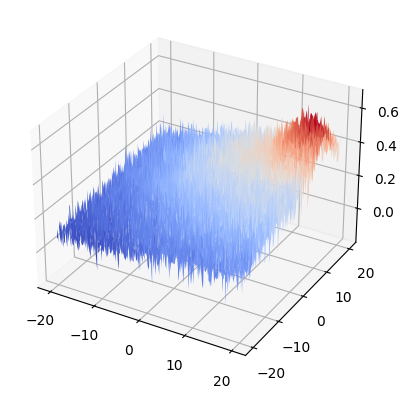

In [22]:
# Plot the surface as a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

## Follow gradient ascent

Once we understand the shape of the parametric surface it is easier to visualize the gradient ascent algorithm. We see that there is some roughness to the surface, but it has a clear slope upwards. We want to maximize the mutual information between the two images in order to optimize registration. The results of gradient ascent optimization can be superimposed onto the `matplotlib` plot.

In [23]:
n_iterations = 200

In [24]:
transform = TransformType.New()
metric = MetricType.New()
optimizer = OptimizerType.New()
registrar = RegistrationType.New()
interpolator = InterpolatorType.New()

In [25]:
registrar.SetFixedImage(fixed_smoothed_image)
registrar.SetMovingImage(moving_smoothed_image)
registrar.SetOptimizer(optimizer)
registrar.SetTransform(transform)
registrar.SetInterpolator(interpolator)
registrar.SetMetric(metric)

registrar.SetFixedImageRegion(fixed_img.GetBufferedRegion())
registrar.SetInitialTransformParameters(transform.GetParameters())

In [26]:
metric.SetNumberOfSpatialSamples(100)
metric.SetFixedImageStandardDeviation(0.4)
metric.SetMovingImageStandardDeviation(0.4)

optimizer.SetLearningRate(15)
optimizer.SetNumberOfIterations(n_iterations)
optimizer.MaximizeOn()

In [27]:
descent_data = dict()
descent_data[0] = (0, 0)


def log_iteration():
    descent_data[optimizer.GetCurrentIteration() + 1] = tuple(optimizer.GetCurrentPosition())


optimizer.AddObserver(itk.IterationEvent(), log_iteration)

0

In [28]:
registrar.Update()

In [29]:
print(f"Its: {optimizer.GetCurrentIteration()}")
print(f"Final Value: {optimizer.GetValue()}")
print(f"Final Position: {list(registrar.GetLastTransformParameters())}")

Its: 200
Final Value: 0.6287786636295714
Final Position: [13.06874645780319, 16.707359598970985]


In [30]:
x_vals = [descent_data[i][0] for i in range(0, n_iterations)]
y_vals = [descent_data[i][1] for i in range(0, n_iterations)]

We see in the plot that the metric improves as transformation parameters are updated with each iteration. The value of the metric at each step generally increases, yielding a final value very close to the optimal position in the parameter space window.

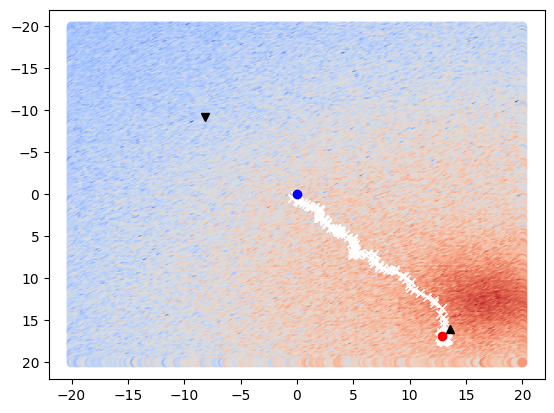

In [31]:
fig = plt.figure()
# Note: We invert the y-axis to represent the image coordinate system
plt.gca().invert_yaxis()
ax = plt.gca()

surf = ax.scatter(X, Y, c=Z, cmap=cm.coolwarm)

for i in range(0, n_iterations - 1):
    plt.plot(x_vals[i : i + 2], y_vals[i : i + 2], "wx-")
plt.plot(descent_data[0][0], descent_data[0][1], "bo")
plt.plot(descent_data[n_iterations - 1][0], descent_data[n_iterations - 1][1], "ro")

plt.plot(max_position[0], max_position[1], "k^")
plt.plot(min_position[0], min_position[1], "kv")

In [32]:
max_position

[13.600000000000001, 16.0]

### Resample the moving image

In order to apply the results of gradient ascent we must resample the moving image into the domain of the fixed image. The `TranslationTransform` whose parameters have been selected through gradient ascent is used to dictate how the moving image is sampled from the fixed image domain. We can compare the two images with `itkwidgets` to verify that registration is successful.

In [33]:
ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
resample = ResampleFilterType.New(
    Transform=transform,
    Input=moving_img,
    Size=fixed_img.GetLargestPossibleRegion().GetSize(),
    OutputOrigin=fixed_img.GetOrigin(),
    OutputSpacing=fixed_img.GetSpacing(),
    OutputDirection=fixed_img.GetDirection(),
    DefaultPixelValue=100,
)

In [34]:
resample.Update()


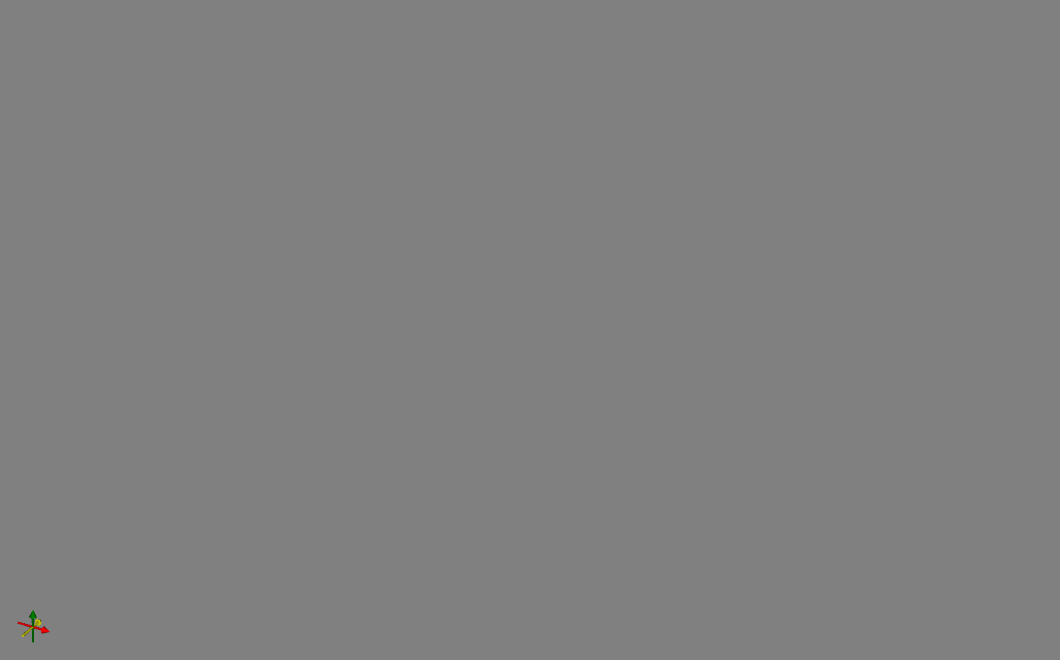
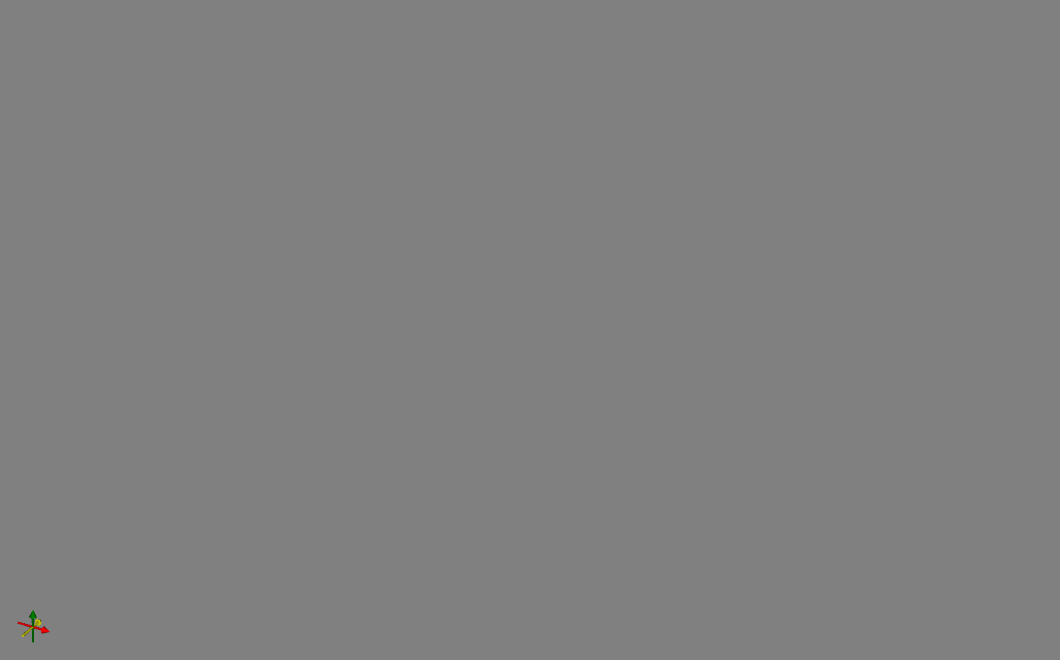

<IPython.core.display.Javascript object>

In [35]:
view(resample.GetOutput())


### Clean up

In [36]:
os.remove(fixed_img_path)
os.remove(moving_img_path)